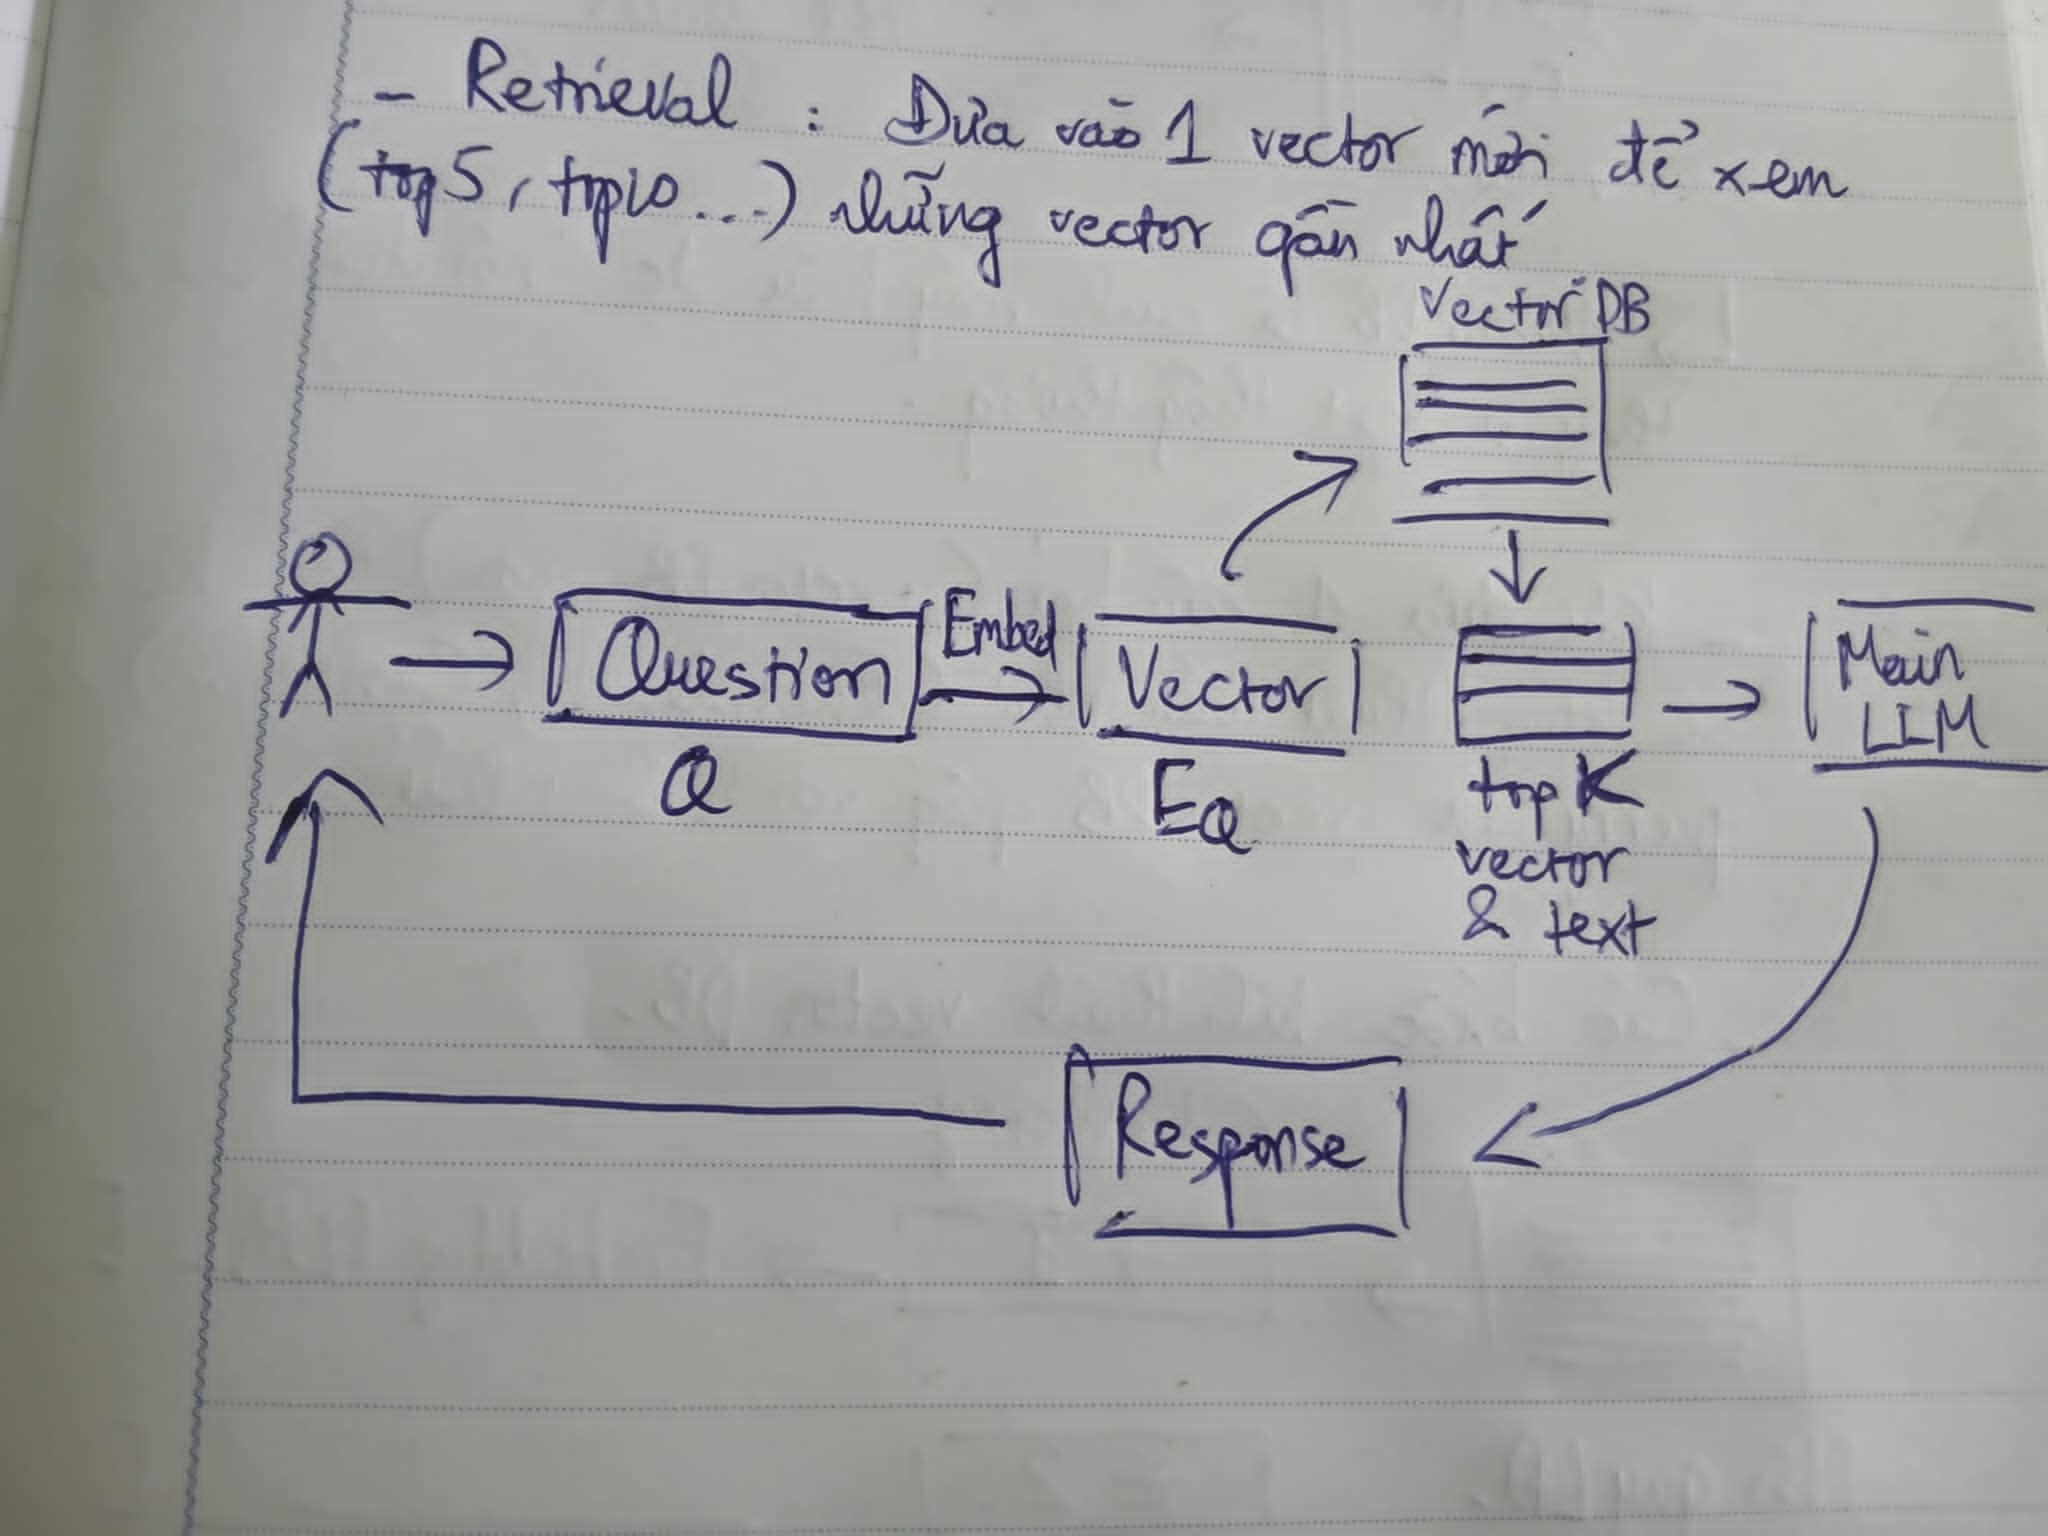

In [1]:
import os
from google.colab import userdata
os.environ["GOOGLE_API_KEY"] = userdata.get('google_api_key')

In [2]:
!pip install -q youtube-transcript-api langchain-community langchain-google-genai faiss-cpu tiktoken python-dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.0/485.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [3]:
!pip install --upgrade youtube-transcript-api

In [4]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate

In [26]:
# Get Document
video_id = "YGBJQsNzcCs"
api = YouTubeTranscriptApi()
try:
    transcript_list = api.fetch(video_id, languages=["en","vi"])
    transcript = " ".join(chunk.text for chunk in transcript_list)
    print(transcript)
except TranscriptsDisabled:
    print("No captions available for this video.")

Xin chào mừng mọi người đến với h ship phiên bản Dark hours Đây là một phiên bản đặc biệt mà chỉ có một tháng một lần lên sóng vào 1200 đêm tối thứ Sáu ở đây thì cũng là uống gì không nhưng mà là uống đồ uống có cồn thì mình cũng chọn khách mời của mình những thiên thần bóng đêm hôm nay nhân dịp tối thứ hai thì chúng ta có hiếu thứ hai Xin chào mừng Hiếu đến với h than kiểu gì xin chào tất cả mọi người Ok và mình lại h thứ hai tâm trạng Em đang thế nào nào em đang hơi bồi hồi chút xíu tại vì lâu lắm rồi em mới uống lại đồ uống có cầ ừ no chia phá Ok tức là tật của em là uống thì đỏ mặt đúng không Dạ Đúng rồi em uống em sẽ bị đỏ mặt nhưng mà em có làm chuyện gì kiểu điên rù cuộc đời em chua giờ làm cái gì điệ rồ hết đó Mọi thứ là nó cảm giác là nó trồ kiểm soát hết á nên là cũng không thích cảm giác mà mình bị mất kiểm soát lắm Ừ ai cũng bắt đầu từ đâu đó ấy ạ Em nghĩ là không phải là hôm nay đâu Thực ra Hiếu thì nhiều khi mình cũng muốn hỏi ngay cái câu này Cái thời gian này kiểu em si

## `Chunking`

In [27]:
splitter = RecursiveCharacterTextSplitter(chunk_size = 1000, chunk_overlap = 200)
chunks = splitter.create_documents([transcript])

In [28]:
chunks

[Document(metadata={}, page_content='Xin chào mừng mọi người đến với h ship phiên bản Dark hours Đây là một phiên bản đặc biệt mà chỉ có một tháng một lần lên sóng vào 1200 đêm tối thứ Sáu ở đây thì cũng là uống gì không nhưng mà là uống đồ uống có cồn thì mình cũng chọn khách mời của mình những thiên thần bóng đêm hôm nay nhân dịp tối thứ hai thì chúng ta có hiếu thứ hai Xin chào mừng Hiếu đến với h than kiểu gì xin chào tất cả mọi người Ok và mình lại h thứ hai tâm trạng Em đang thế nào nào em đang hơi bồi hồi chút xíu tại vì lâu lắm rồi em mới uống lại đồ uống có cầ ừ no chia phá Ok tức là tật của em là uống thì đỏ mặt đúng không Dạ Đúng rồi em uống em sẽ bị đỏ mặt nhưng mà em có làm chuyện gì kiểu điên rù cuộc đời em chua giờ làm cái gì điệ rồ hết đó Mọi thứ là nó cảm giác là nó trồ kiểm soát hết á nên là cũng không thích cảm giác mà mình bị mất kiểm soát lắm Ừ ai cũng bắt đầu từ đâu đó ấy ạ Em nghĩ là không phải là hôm nay đâu Thực ra Hiếu thì nhiều khi mình cũng muốn hỏi ngay cái

In [29]:
#Nhét vào vector DB
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001") #<-- embedding LLMs
vector_store = FAISS.from_documents(chunks, embeddings)

In [32]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs = {"k":4}) #Lấy 4 thằng vector gần nhất
retriever.invoke("Nghề nghiệp của Hiếu thứ hai")

[Document(id='b7ab6ab8-3640-42ec-b7a0-cf905329a4b2', metadata={}, page_content='của em chị nghĩ là sẽ còn dài với kiểu suy nghĩ như thế này với tư duy như thế này và chị cũng cảm ơn Hiếu bởi vì là nếu không gặp em và nếu không phảng vấn em có thể chị sẽ có một cái kiểu suy nghĩ về em cũng sẽ rất giống nhiều người ngoài kia không có hiểu rõ em dạ đấy và hy vọng cái điều này cũng là điều khán giả cảm thấy Ờ cũng lần đầu tiên thì mình giống mọi người thôi lần đầu tiên trò chuyện với Hiếu thứ hai Và mình cũng tin là những gì Hiếu chia sẻ ngày hôm nay là một cái cơ hội rất là quý là mình đã ngồi bên nhau Cảm ơn Hiếu nhá và cảm ơn tất cả mọi người xin chào và hẹn gặp lại mọi người trong những tập tiếp theo [âm nhạc] [âm nhạc] ah'),
 Document(id='b1292e15-e39b-46fe-b4a0-dae57f506ea9', metadata={}, page_content='đi Hai Hai một đêm Á tại vì vào chương trình á nhiều người có tới hồi đó mình cũng mình cũng là một cái người giống vậy nè Ủa thì nó cũng là quăng miếng thôi mà ý là vô ráp ủi lộn vô d

In [33]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.2)

prompt = PromptTemplate(
    template = """
      You are a helpful assistance.
      Answer ONLY from the provided transcript context.
      If the context is insufficient, just say you don't know.

      {context}
      Question: {question}
    """,
    input_variables=["context", "question"]
)

In [36]:
question = "Sau chương trình thì mình cảm thấy thế nào?"
retrieved_docs = retriever.invoke(question)

context_text = "\n\n".join(doc.page_content for doc in retrieved_docs)
final_prompt = prompt.invoke({"context":context_text, "question": question})
answer = llm.invoke(final_prompt)
print(answer)

content='Sau chương trình thì mình có nhiều show hơn và cảm thấy mình làm được rồi,  nhưng mọi thứ vẫn còn bấp bênh.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-1.5-flash', 'safety_ratings': []} id='run--d697f945-9409-447a-bc47-8f73404a65fd-0' usage_metadata={'input_tokens': 988, 'output_tokens': 30, 'total_tokens': 1018, 'input_token_details': {'cache_read': 0}}
